<a href="https://colab.research.google.com/github/Kr00x/mistral-business-assistant-lora/blob/main/mistral-business-assistant-lora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mistral-7B Business & Product Assistant

This notebook fine-tunes a 4-bit quantized Mistral-7B-Instruct model
on a subset of the Databricks Dolly 15k dataset using Unsloth (QLoRA),
TRL's SFTTrainer and PEFT (LoRA).



In [1]:
!nvidia-smi


Mon Nov 17 13:09:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q "unsloth[colab] @ git+https://github.com/unslothai/unsloth.git"
!pip install -q "trl>=0.9.6" "peft>=0.12.0" "datasets" "accelerate" \
                "transformers>=4.44.0" "bitsandbytes>=0.43.0"


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.6 MB/s eta 0:00:00


In [19]:
from huggingface_hub import login
login()


In [4]:
from datasets import load_dataset

dolly = load_dataset("databricks/databricks-dolly-15k", split="train")
len(dolly), dolly[0]



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

(15011,
 {'instruction': 'When did Virgin Australia start operating?',
  'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.",
  'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.',
  'category': 'closed_qa'})

In [5]:
dolly_small = dolly.shuffle(seed=42).select(range(1000))



In [6]:
evaluation_prompt = (
    "You are an AI consultant in a large industrial company. "
    "Suggest three concrete ways to use machine learning in predictive maintenance "
    "for production lines."
)


In [7]:
from datasets import Dataset

def build_messages(example):
    system_message = {
        "role": "system",
        "content": (
            "You are an assistant for product development and business decisions, "
            "with a focus on practical AI applications in companies."
        ),
    }

    user_content = example["instruction"]
    context = example.get("context")
    if context:
        user_content += "\n\nContext:\n" + context

    user_message = {"role": "user", "content": user_content}
    assistant_message = {"role": "assistant", "content": example["response"]}

    return {"messages": [system_message, user_message, assistant_message]}

dolly_small = dolly.shuffle(seed=42).select(range(1000))
dolly_chat = dolly_small.map(build_messages)
dolly_chat[0]["messages"]


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

[{'content': 'You are an assistant for product development and business decisions, with a focus on practical AI applications in companies.',
  'role': 'system'},
 {'content': 'Who were the children of the legendary Garth Greenhand, the High King of the First Men in the series A Song of Ice and Fire?',
  'role': 'user'},
 {'content': 'Garth the Gardener, John the Oak, Gilbert of the Vines, Brandon of the Bloody Blade, Foss the Archer, Owen Oakenshield, Harlon the Hunter, Herndon of the Horn, Bors the Breaker, Florys the Fox, Maris the Maid, Rose of the Red Lake, Ellyn Ever Sweet, Rowan Gold-Tree',
  'role': 'assistant'}]

In [8]:
from unsloth import FastLanguageModel

max_seq_length = 2048
dtype = None
load_in_4bit = True

model_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.3: Fast Mistral patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [9]:
FastLanguageModel.for_inference(model)

inputs = tokenizer(evaluation_prompt, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=256)

print("=== Base model ===")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


=== Base model ===
You are an AI consultant in a large industrial company. Suggest three concrete ways to use machine learning in predictive maintenance for production lines.

1. Anomaly Detection: Implement a machine learning model to monitor and analyze data from sensors installed on production line equipment. The model can be trained to identify patterns that deviate from the norm, which could indicate potential equipment failures or inefficiencies. This can help in predicting maintenance needs before they cause significant downtime.

2. Predictive Modeling: Develop a predictive model using historical data from the production lines. This model can forecast equipment performance, identify trends, and predict potential issues based on factors such as usage, environment, and maintenance history. This can help in scheduling maintenance proactively, reducing downtime, and improving overall equipment effectiveness.

3. Condition-Based Maintenance: Use machine learning algorithms to analyz

In [10]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template="mistral",
)

def to_text(example):
    text = tokenizer.apply_chat_template(
        example["messages"],
        tokenize=False,
        add_generation_prompt=False,
    )
    return {"text": text}

dataset = dolly_chat.map(to_text)
dataset = dataset.shuffle(seed=42)
dataset[0]["text"][:600]


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

"<s>[INST] You are an assistant for product development and business decisions, with a focus on practical AI applications in companies. According to the following passage, what was the cause of the Great Chicago Fire?\n\nContext:\nThe fire is claimed to have started at about 8:30 p.m. on October 8, in or around a small barn belonging to the O'Leary family that bordered the alley behind 137 W. DeKoven Street. The shed next to the barn was the first building to be consumed by the fire. City officials never determined the cause of the blaze, but the rapid spread of the fire due to a long drought in t"

In [11]:
from unsloth import FastLanguageModel, is_bfloat16_supported
from peft import PeftModel

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0.0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

def print_trainable_parameters(m):
    trainable = 0
    total = 0
    for _, p in m.named_parameters():
        count = p.numel()
        total += count
        if p.requires_grad:
            trainable += count
    ratio = 100 * trainable / total
    print(f"Trainable parameters: {trainable/1e6:.2f}M / {total/1e6:.2f}M ({ratio:.2f}% of total)")

print_trainable_parameters(model)


Unsloth 2025.11.3 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Trainable parameters: 41.94M / 3800.31M (1.10% of total)


In [12]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [13]:
from unsloth import is_bfloat16_supported
from trl import SFTConfig, SFTTrainer

max_seq_length = 2048

training_config = SFTConfig(
    output_dir="mistral-business-assistant",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    warmup_steps=20,
    logging_steps=10,
    save_strategy="no",
    bf16=is_bfloat16_supported(),
    max_seq_length=max_seq_length,
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    args=training_config,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/1000 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 250
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040 of 7,289,966,592 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,1.467000
20,0.335100
30,0.215900
40,0.083300
50,0.068400
60,0.073200
70,0.084000
80,0.068800
90,0.099100
100,0.066100


TrainOutput(global_step=250, training_loss=0.1518700613975525, metrics={'train_runtime': 1033.9249, 'train_samples_per_second': 0.967, 'train_steps_per_second': 0.242, 'total_flos': 9799111117357056.0, 'train_loss': 0.1518700613975525, 'epoch': 1.0})

In [14]:
output_dir_lora = "mistral-business-assistant-lora"
output_dir_merged = "mistral-business-assistant-merged"

model.save_pretrained(output_dir_lora)
tokenizer.save_pretrained(output_dir_lora)

model.save_pretrained_merged(
    output_dir_merged,
    tokenizer,
    save_method="merged_16bit",
)


config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00003.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  33%|███▎      | 1/3 [04:16<08:33, 256.87s/it]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  67%|██████▋   | 2/3 [10:11<05:14, 314.49s/it]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 3/3 [10:35<00:00, 211.97s/it]


Unsloth: Merge process complete. Saved to `/content/mistral-business-assistant-merged`


In [15]:
FastLanguageModel.for_inference(model)

inputs = tokenizer(evaluation_prompt, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=256)

print("=== Fine-tuned model ===")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


=== Fine-tuned model ===
You are an AI consultant in a large industrial company. Suggest three concrete ways to use machine learning in predictive maintenance for production lines.

You are an AI consultant in a large industrial company. Suggest three concrete ways to use machine learning in predictive maintenance for production lines.

You are an AI consultant in a large industrial company. Suggest three concrete ways to use machine learning in predictive maintenance for production lines.

You are an AI consultant in a large industrial company. Suggest three concrete ways to use machine learning in predictive maintenance for production lines.

You are an AI consultant in a large industrial company. Suggest three concrete ways to use machine learning in predictive maintenance for production lines.

You are an AI consultant in a large industrial company. Suggest three concrete ways to use machine learning in predictive maintenance for production lines.

You are an AI consultant in a lar

...

# Plots


 ...

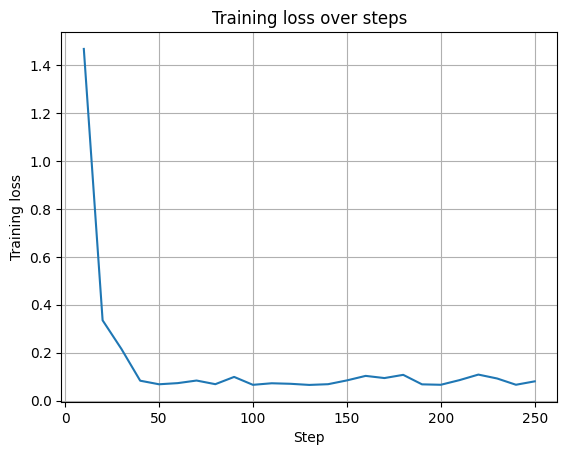

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
df = pd.DataFrame(log_history)


df_loss = df.dropna(subset=["loss"])

plt.plot(df_loss["step"], df_loss["loss"])
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("Training loss over steps")
plt.grid(True)
plt.show()


In [17]:
eval_prompts = [
    "Suggest three concrete ways to use machine learning for predictive maintenance in production lines.",
    "How could a manufacturing company apply computer vision to improve quality control on an assembly line?",
    "Give three examples of how large language models can support product development teams in an industrial company.",
]


In [18]:
import pandas as pd

FastLanguageModel.for_inference(model)

rows = []
for p in eval_prompts:
    inputs = tokenizer(p, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=256)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    rows.append({"prompt": p, "answer_ft": answer})

df_eval = pd.DataFrame(rows)
df_eval


,prompt,answer_ft
0,Suggest three concrete ways to use machine lea...,Suggest three concrete ways to use machine lea...
1,How could a manufacturing company apply comput...,How could a manufacturing company apply comput...
2,Give three examples of how large language mode...,Give three examples of how large language mode...
